## PHY 411: Final Project
### Jeremy Kazimer
### jdkazime@buffalo.edu

#### _Import Statements_

To begin this portion of the project, we import the Python file I created which contains the network class and its methods.  We also import the file which contains the entropy methods:

In [1]:
from generate_network import *
from calculate_entropy import *

We'll also want to import `numpy` and `matplotlib`:

In [2]:
import numpy as np
from matplotlib import pyplot as plt

Now, the analysis can begin:

#### _Generate Network_

Since edge rankings are best defined for community structure, we can opt to form an SBM with the conditions $N = 100$, $k = 2$, $p_{in} = 0.5$, and $p_{out} = 0.05$:

In [3]:
N = 100
k = 2
p_in = 0.5
p_out = 0.05

In [4]:
G = SBM(N, p_in, p_out, k = k)

In [5]:
edge_colors, locs = G.get_edge_colors('grey', 'red')

And, of course, the `networkx` plot:

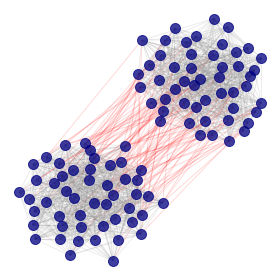

In [6]:
fig, ax = G.plot_networkx(edge_color = edge_colors)

#### _Ranking this Graph_

Now, we can calculate the rankings on a static time domain.  That is to say, there is no rewiring such that we treat each instance of rewiring as a frame of motion.  So, basically, the time state.  We'll start with $\beta = 1$:

In [7]:
Hs, sorts, ranks = edge_rankings(G)

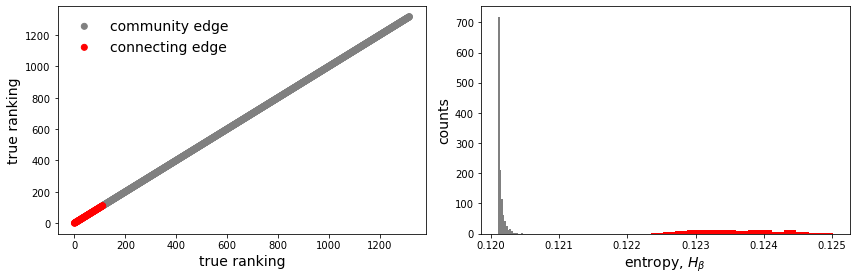

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

axs[0].scatter(ranks[locs], ranks[locs], c = edge_colors[locs].flatten(), label = 'community edge')
axs[0].scatter(ranks[~locs], ranks[~locs], c = edge_colors[~locs].flatten(), label = 'connecting edge')
axs[0].legend(loc = 'upper left', fontsize = 14, frameon = False)

axs[0].set_xlabel('true ranking', fontsize = 14)
axs[0].set_ylabel('true ranking', fontsize = 14)


axs[1].hist(Hs[locs], 15, color = edge_colors[locs][0])
axs[1].hist(Hs[~locs], 15, color = edge_colors[~locs][0])

axs[1].set_ylabel('counts', fontsize = 14)
axs[1].set_xlabel(r'entropy, $H_\beta$', fontsize = 14)

fig.tight_layout()

Here, we plot the rankings against themselves to highlight which edges are most important.  Here, it is clear that the connecting edges are most important.  And from the figure on the right, this is because their removal generates the most entropy.  Like, there is a clear disconnect.  

However, the current metric is kind of silly.  We can devise something better.  How about of the top 10% of edges, how many of which are the connecting edges?

In [53]:
def top_ranked(sorts, locs, cutoff = 0.10):
    
    cutoff_idx = int(cutoff*sorts.shape[0])
    if cutoff_idx == sorts.shape[0]:
        is_connecting = ~locs[sorts]
    else:
        is_connecting = ~locs[sorts][:cutoff_idx]
    
    is_connecting = is_connecting.sum()/is_connecting.shape[0]
    
    return is_connecting*100
    

In [54]:
print(top_ranked(sorts, locs))

85.49618320610686


So, pretty good.  Now, we can ditch the above plots in favor of this metric.  Of course, it'll require some tinkering, but we can try that now...

In [61]:
cutoffs = np.linspace(1, 100, 101)/100
percents = np.zeros(cutoffs.shape[0])

for idx, cutoff in enumerate(cutoffs):
    
    percents[idx] = top_ranked(sorts, locs, cutoff = cutoff)

Text(0.5, 0, 'cutoff percentage, $x$')

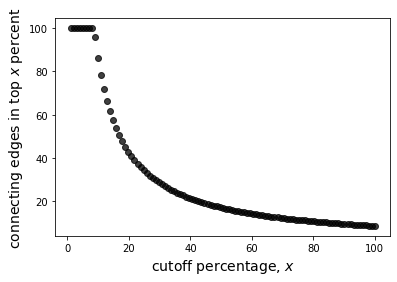

In [79]:
fig, ax = plt.subplots(1, 1)

ax.scatter(cutoffs*100, percents, c = 'k', alpha = 0.75)

ax.set_ylabel('connecting edges in top $x$ percent', fontsize = 14)
ax.set_xlabel('cutoff percentage, $x$', fontsize = 14)

Makes sense.  It eventually converges to being probably the proportion of total connecting edges to total community edges.  We can check this:

In [77]:
print(G.outside_edges.shape[0]/G.inside_edges.shape[0] * 100 - percents[-1])

0.7891750151619235


So, it's not quite, but it's close.  Not a big deal, since we'll never look at the end cases since that defeats the purpose of this experiment.  However, we do see a rather flat curve near the early cutoffs, just under 10.  As such, what value of $x$ does this correspond to for the last of this flat curve?

In [86]:
print(cutoffs[percents == 100][-1])

0.0793


There's really nothing special about this value, other than it's right under the limit of the proportion of connecting to community edges: 

In [89]:
print(G.outside_edges.shape[0]/G.inside_edges.shape[0] * 100)

9.286898839137644


As such, for this next experiment, this is percentage that we'll use, this proportion.

#### _Rankings by Time-Scale Parameter